In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import numpy as onp
import jax.numpy as np
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp
from functools import partial

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

## Gaussian Mixture

In [3]:
from dist import GaussianMixture
mixture = GaussianMixture(np.array([-10, 10]), np.array([1, 1]))
grad_log_p = jax.jit(jax.grad(mixture.log_p))

2024-07-17 20:23:01.048392: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
rng = jax.random.PRNGKey(50)
rng, key = jax.random.split(rng)
data = mixture.sample(10000, key)

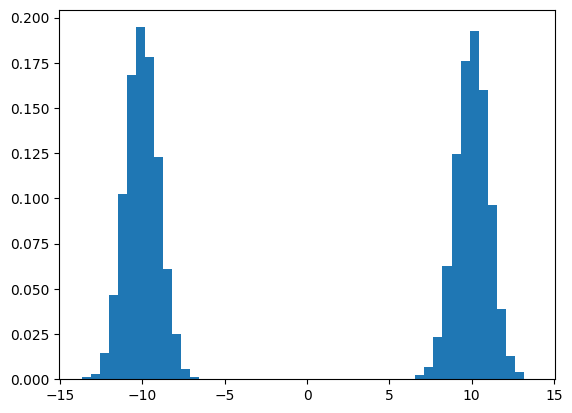

In [5]:
#plt.scatter(data[:,0], data[:,1], alpha=0.7)
plt.hist(data, bins=50, density=True)
plt.show()

## Langevin Dynamics (ULA)

In [6]:
from mcmc import LangevinDynamics

In [7]:
def multichain_sample(sampler: eqx.Module, dim: int, key: jax.random.PRNGKey, n_chains: int = 1000, init_std: float = 5):
    starter_points = jax.random.normal(key, shape=(n_chains, 1, dim)) * init_std
    starter_keys = jax.random.split(key, n_chains)

    _, samples = jax.vmap(sampler)(starter_points, starter_keys)
    samples = samples.reshape(-1, dim)
    return samples

In [8]:
rng, key = jax.random.split(rng)
sampler = LangevinDynamics(gradient_func=grad_log_p, n_samples=500, gamma=5e-2, burnin_steps=100)
samples = multichain_sample(sampler, 1, key, n_chains = 100)

13.409479


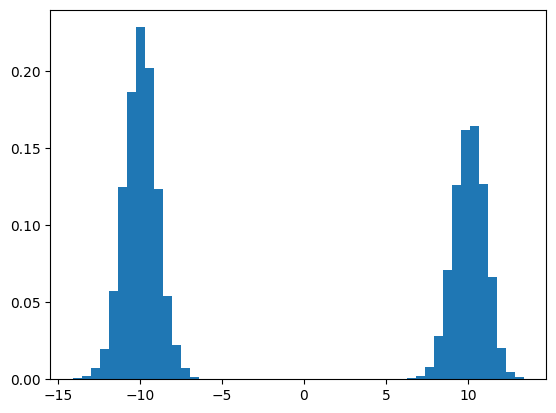

In [9]:
#plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
print(samples.max())
plt.hist(samples, bins=50, density=True)
plt.show()

## Baseline
Using a sample mean as an integral estimate

In [10]:
def mcmc_baseline(fn: tp.Callable, sampler: eqx.Module, dim: int, key: jax.random.PRNGKey, n_chains: int = 1000):
    samples = multichain_sample(sampler, dim, key, n_chains)
    return jax.vmap(fn)(samples).mean()

In [11]:
fn = jax.jit(lambda x: x.sum(axis=-1))

3.957603


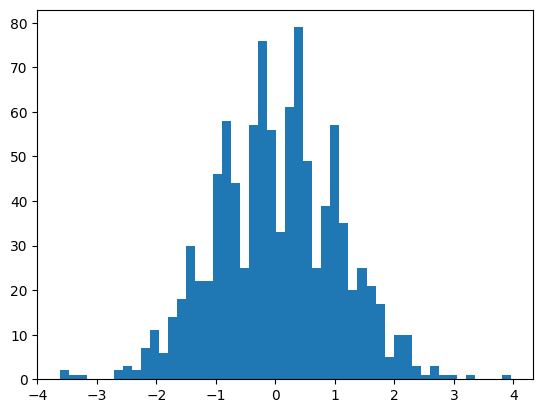

In [12]:
n_runs = 1000

# Run without vmap because of OOM
mcmc_estimates = []
for key in jax.random.split(rng, n_runs):
    mcmc_estimates.append(mcmc_baseline(fn, sampler, 1, key, n_chains = 100))   
mcmc_estimates = np.stack(mcmc_estimates)

print(mcmc_estimates.max())
plt.hist(mcmc_estimates, bins=50)
plt.show()

## Control variates
Train a NN with an objective from "Diffusion Approximations and Control Variates for MCMC"

In [13]:
from diffcv.cv import ControlVariateModel, fit_cv, cv_loss
import jax_dataloader as jdl
from utils import inf_loop

2024-07-17 20:23:35.603804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 20:23:35.603841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 20:23:35.603881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 20:23:36.306585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
rng, key = jax.random.split(rng)
training_samples = multichain_sample(sampler, 1, key, n_chains = 100)
dataset = jdl.ArrayDataset(training_samples)
dataloader = jdl.DataLoader(
    dataset,
    backend="jax",
    batch_size=1024,
    shuffle=True
)
dataloader = inf_loop(dataloader)
len(dataset)

40000

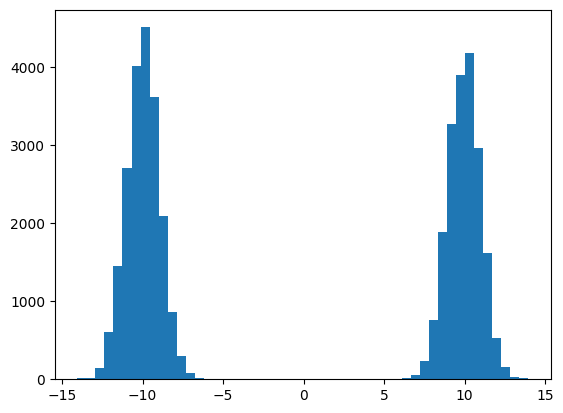

In [15]:
plt.hist(dataset.arrays[0], bins=50)
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

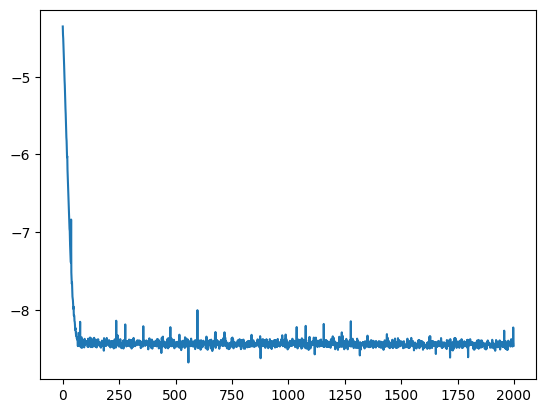

In [18]:
rng, key = jax.random.split(rng)
cv_model = ControlVariateModel(in_size=1, width_size=32, key=key)
optimizer = optax.adam(learning_rate=1e-4)

cv_model, loss_history = fit_cv(
    cv_model, 
    fn,
    dataloader,  
    optimizer,
    cv_loss, 
    n_steps=2000,
)

plt.plot(loss_history)
plt.show()

In [19]:
from diffcv.cv import Generator

0.42758307


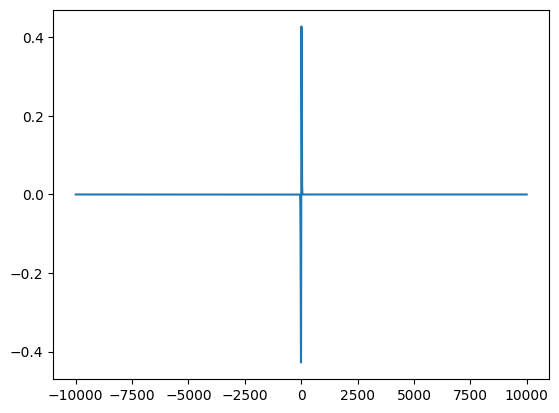

In [20]:
x = np.linspace(-10_000, 10_000, 10_000)
y = jax.vmap(cv_model)(x.reshape(-1, 1))
print(y.max())
plt.plot(x, y);

In [21]:
generator = Generator(grad_log_p, cv_model)
jax.vmap(generator)(dataset.arrays[0]).mean()

Array(-4.2930305e-06, dtype=float32)

In [22]:
fn_with_cv = lambda x: fn(x) + generator(x)

nan
[nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]


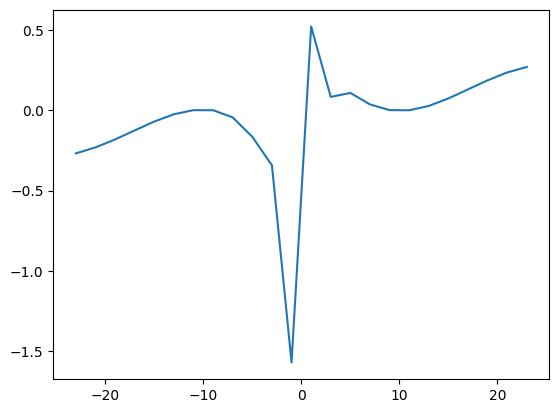

In [23]:
x = np.linspace(-10_000, 10_000, 10_000)
y = jax.vmap(generator)(x.reshape(-1, 1))
print(y.max())
print(y[:10], y[-10:])
plt.plot(x, y);

3.2150466


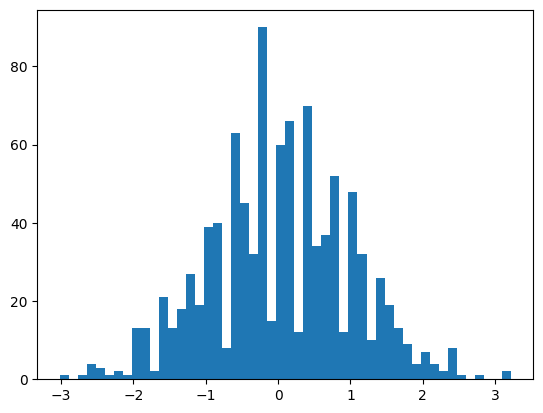

In [24]:
n_runs = 1000

# Run without vmap because of OOM
mcmc_with_cv_estimates = []
for key in jax.random.split(rng, n_runs):
    mcmc_with_cv_estimates.append(mcmc_baseline(fn_with_cv, sampler, 1, key, n_chains = 100))   
mcmc_with_cv_estimates = np.stack(mcmc_with_cv_estimates)

print(mcmc_with_cv_estimates.max())
plt.hist(mcmc_with_cv_estimates, bins=50)
plt.show()

In [25]:
mcmc_estimates.mean(), mcmc_estimates.std()

(Array(0.03064311, dtype=float32), Array(1.0409446, dtype=float32))

In [26]:
mcmc_with_cv_estimates.mean(), mcmc_with_cv_estimates.std()

(Array(0.02894096, dtype=float32), Array(0.98304707, dtype=float32))